## 1. Data Cleaning and Initial Analysis

In [71]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [72]:
# Load the dataset
file_path = '/Users/susu/Downloads/online_retail-3.csv'
original_data = pd.read_csv(file_path)
data = original_data.copy()
# Display the last few rows of the dataset to understand its structure
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [73]:
data.shape

(541909, 8)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [75]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [76]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [77]:
# Handling missing values
# drop rows where 'CustomerID' is NA
data = data.dropna(subset=['CustomerID'])

In [78]:
# Remove duplicates
data.drop_duplicates(inplace=True)

In [79]:
negative_data = data[(data['Quantity'] < 0) | (data['UnitPrice'] < 0)]


In [80]:
# Address anomalies such as negative quantities and prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [81]:
# Validate and correct data types
# Convert 'InvoiceDate' to datetime if not already
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Descriptive statistics to understand the distribution and nature of data
data.describe()


,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


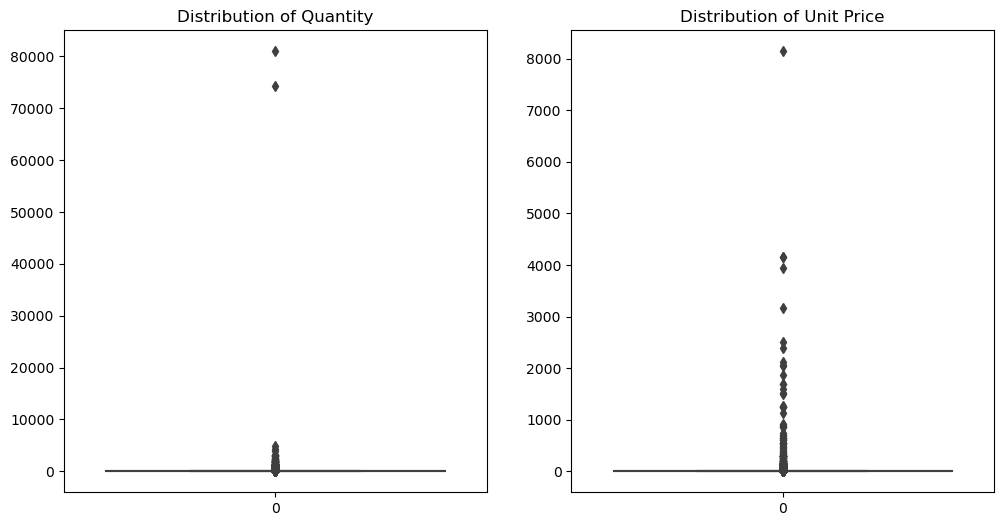

In [82]:

# Visualize distributions of key numerical features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data['Quantity'])
plt.title('Distribution of Quantity')

plt.subplot(1, 2, 2)
sns.boxplot(data['UnitPrice'])
plt.title('Distribution of Unit Price')
plt.show()



### Cohort Analysis

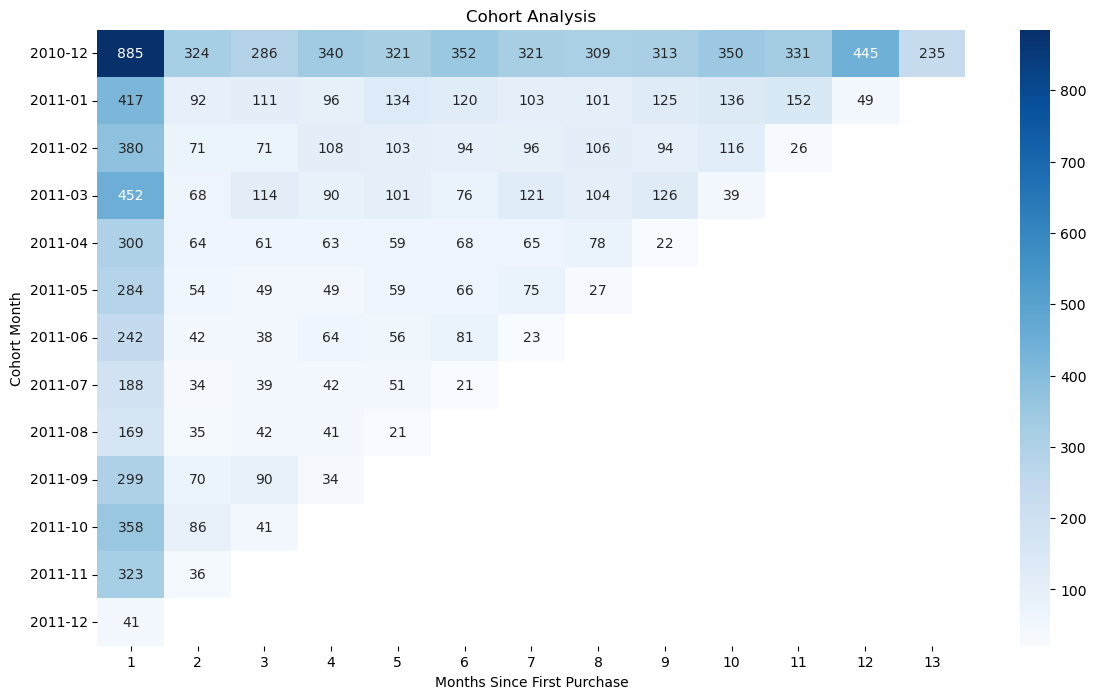

In [83]:
# Create CohortMonth and OrderMonth
data['OrderMonth'] = data['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').apply(lambda x: x.strftime('%Y-%m'))

# Create a cohort group based on the CustomerID
data['CohortIndex'] = (pd.to_datetime(data['OrderMonth']).dt.year - pd.to_datetime(data['CohortMonth']).dt.year) * 12 + \
    (pd.to_datetime(data['OrderMonth']).dt.month - pd.to_datetime(data['CohortMonth']).dt.month) + 1

# Aggregate data by cohort
cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_count = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Visualize with heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cohort_count, annot=True, fmt='g', cmap='Blues')
plt.title('Cohort Analysis')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()


## 2. Sales Performance Analysis


In [84]:

# Create new columns for Year, Month, Day, and Hour from 'InvoiceDate' for detailed analysis
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Hour'] = data['InvoiceDate'].dt.hour
data['Weekday'] = data['InvoiceDate'].dt.day_name()


In [85]:
# Calculate total sales for each transaction
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderMonth,CohortMonth,CohortIndex,Year,Month,Day,Hour,Weekday,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12,1,2010,12,1,8,Wednesday,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1,2010,12,1,8,Wednesday,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12,1,2010,12,1,8,Wednesday,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1,2010,12,1,8,Wednesday,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1,2010,12,1,8,Wednesday,20.34


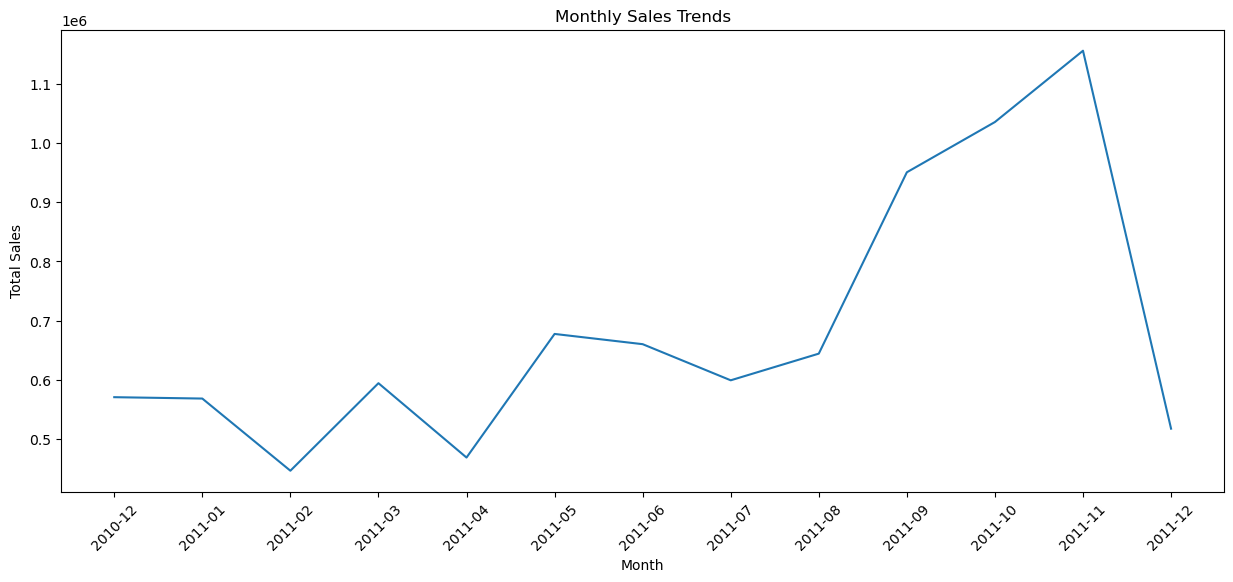

In [86]:
# Aggregate data to see total sales per month
monthly_sales = data.groupby(['Year', 'Month']).agg({'TotalSales': 'sum'}).reset_index()

# Combine 'Year' and 'Month' into a single string column for better plotting, applying 'zfill' on each element
monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).apply(lambda x: x.zfill(2))

# Plot monthly sales trends
plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='TotalSales')
plt.xticks(rotation=45)
plt.title('Monthly Sales Trends')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.show()


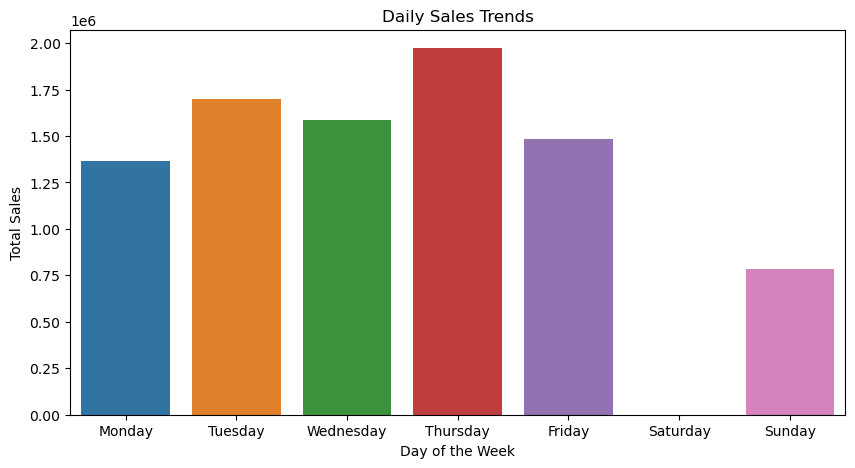

In [87]:
# Daily sales analysis
daily_sales = data.groupby(['Weekday']).agg({'TotalSales': 'sum'}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot daily sales trends
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_sales.index, y='TotalSales', data=daily_sales)
plt.title('Daily Sales Trends')
plt.ylabel('Total Sales')
plt.xlabel('Day of the Week')
plt.show()


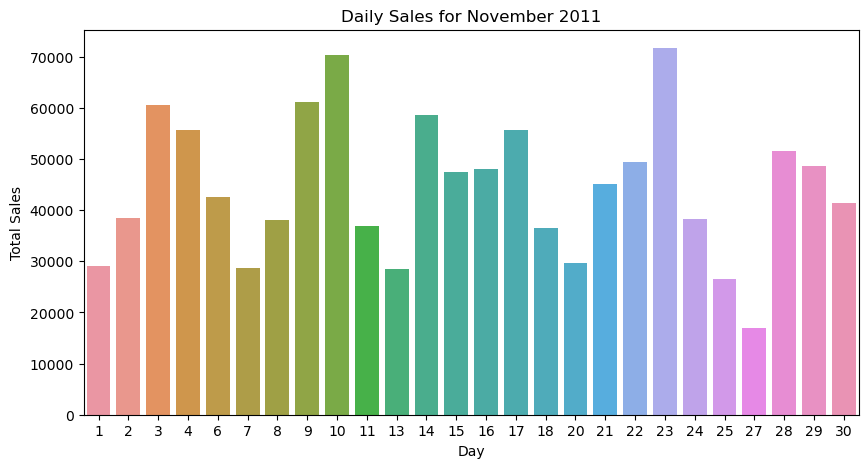

In [88]:
# Analyze specific periods such as November 2011
nov_2011_sales = data[(data['Year'] == 2011) & (data['Month'] == 11)]
nov_2011_daily_sales = nov_2011_sales.groupby('Day').agg({'TotalSales': 'sum'})

# Plot daily sales for November 2011
plt.figure(figsize=(10, 5))
sns.barplot(x=nov_2011_daily_sales.index, y='TotalSales', data=nov_2011_daily_sales)
plt.title('Daily Sales for November 2011')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.show()


## 3. Customer Segmentation

### Feature Engineering for Customer Segmentation

In [89]:
# Set the current date to the maximum 'InvoiceDate' plus one day
current_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# Create a dataframe with customer id as the index
customers = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalSales': 'sum'  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
})

# Display the first few rows
customers.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## 4. Product Analysis

### 1: Identifying Top-Selling Products

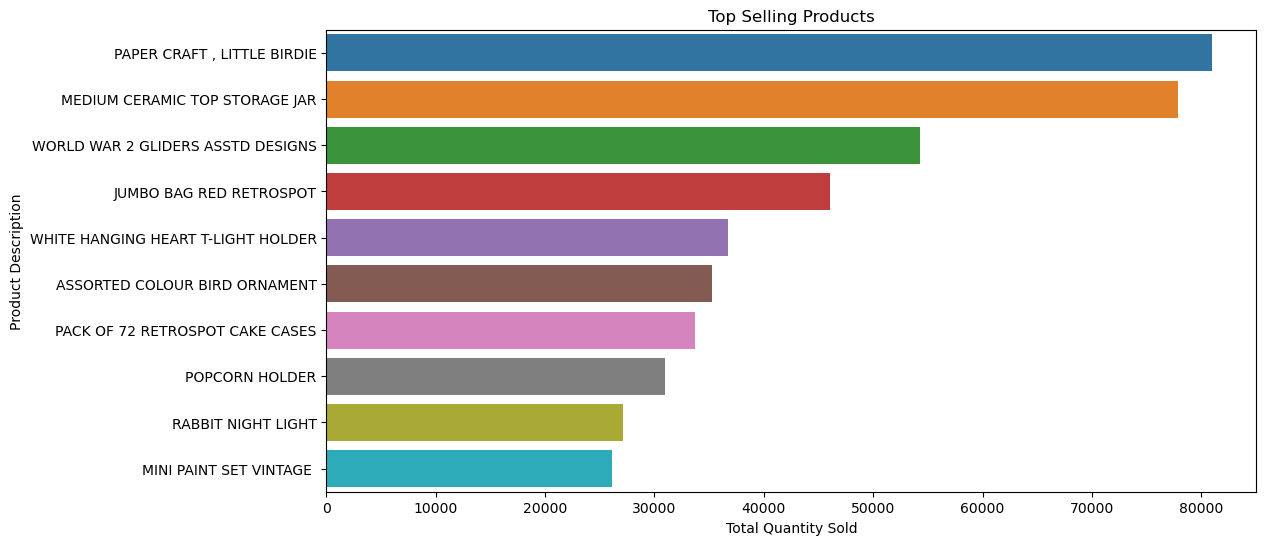

In [90]:
# Aggregate data to find the top-selling products
top_selling_products = data.groupby('Description').agg({
    'Quantity': 'sum'
}).sort_values(by='Quantity', ascending=False).head(10)  # Adjust the number to view more products

# Plot the top-selling products
plt.figure(figsize=(12, 6))
sns.barplot(x=top_selling_products['Quantity'], y=top_selling_products.index)
plt.title('Top Selling Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.show()


### 2: Analyzing Most Often Returned Products

Top 5 Most Returned Products:
                          Quantity
Description                       
REGENCY CAKESTAND 3 TIER       180
Manual                         175
POSTAGE                         97
JAM MAKING SET WITH JARS        86
Discount                        77


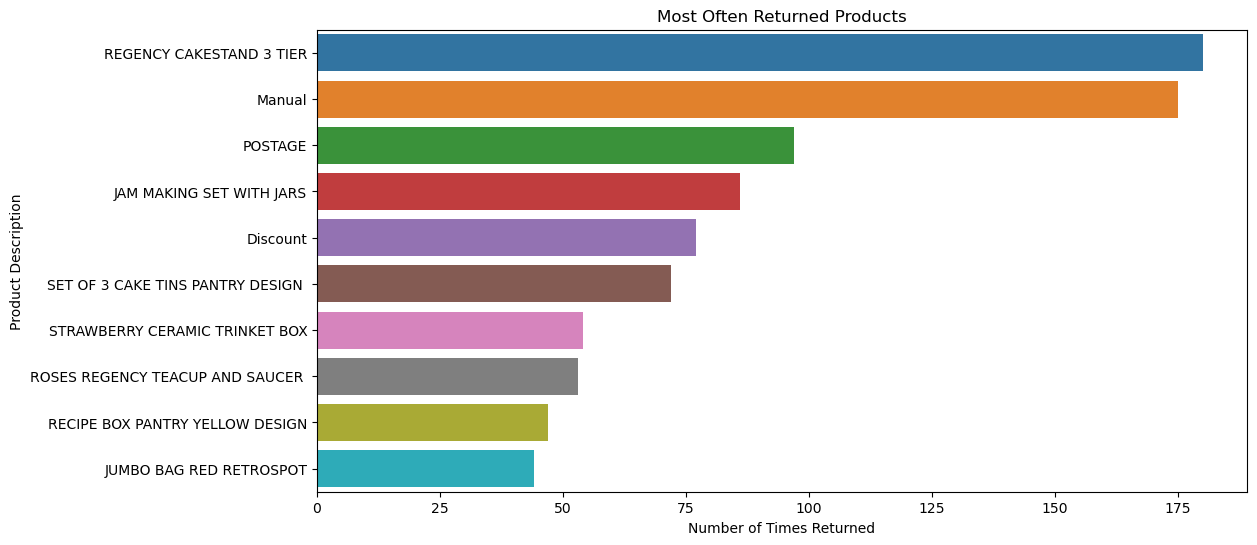

In [93]:
# Ensure you're filtering negative_data for negative quantities specifically for this analysis
returned_data = negative_data[negative_data['Quantity'] < 0]

# Check if returned_data is empty
if not returned_data.empty:
    # Aggregate to find products that are most often returned
    most_returned_products = returned_data.groupby('Description').agg({
        'Quantity': 'count'
    }).sort_values(by='Quantity', ascending=False).head(10)  # Adjust the number to view more products
    print("Top 5 Most Returned Products:")
    print(most_returned_products_top5)
    # Plot the most often returned products
    plt.figure(figsize=(12, 6))
    sns.barplot(x=most_returned_products['Quantity'], y=most_returned_products.index)
    plt.title('Most Often Returned Products')
    plt.xlabel('Number of Times Returned')
    plt.ylabel('Product Description')
    plt.show()
else:
    print("There are no negative quantities in the data.")


Top 5 Bulk Orders Returned:
                                     Quantity
Description                                  
PAPER CRAFT , LITTLE BIRDIE            -80995
MEDIUM CERAMIC TOP STORAGE JAR         -74494
ROTATING SILVER ANGELS T-LIGHT HLDR     -9367
Manual                                  -3995
FAIRY CAKE FLANNEL ASSORTED COLOUR      -3150


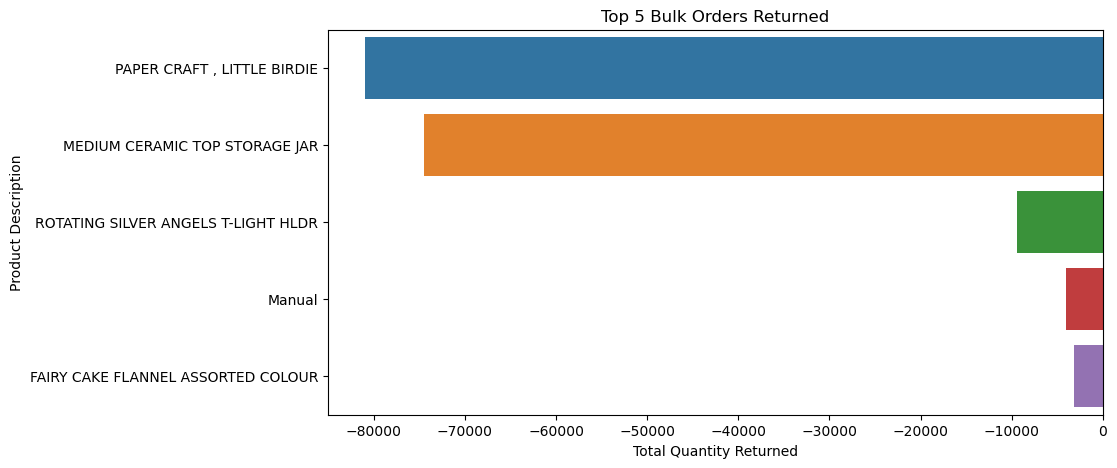

In [99]:
# DataFrame for top 5 bulk orders returned
top5_bulk_returns = negative_data[negative_data['Quantity'] < 0].groupby('Description').agg({
    'Quantity': 'sum'
}).sort_values(by='Quantity').head(5)

print("Top 5 Bulk Orders Returned:")
print(top5_bulk_returns)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=top5_bulk_returns['Quantity'], y=top5_bulk_returns.index)
plt.title('Top 5 Bulk Orders Returned')
plt.xlabel('Total Quantity Returned')
plt.ylabel('Product Description')
plt.show()


Top 5 Customers by Order Cancellations:
            InvoiceNo
CustomerID           
14911.0           226
17841.0           136
17511.0           113
15311.0           112
12607.0           101


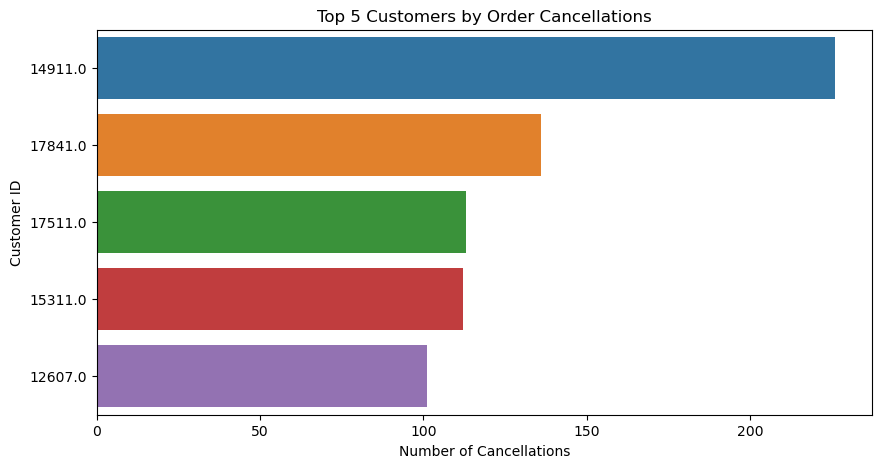

In [100]:
# DataFrame for top 5 customers by order cancellations
top5_cancellers = negative_data[negative_data['Quantity'] < 0].groupby('CustomerID').agg({
    'InvoiceNo': 'count'
}).sort_values(by='InvoiceNo', ascending=False).head(5)

print("Top 5 Customers by Order Cancellations:")
print(top5_cancellers)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=top5_cancellers['InvoiceNo'], y=top5_cancellers.index.astype(str))
plt.title('Top 5 Customers by Order Cancellations')
plt.xlabel('Number of Cancellations')
plt.ylabel('Customer ID')
plt.show()


Top 10 Products by Revenue:
                                    TotalSales
Description                                   
PAPER CRAFT , LITTLE BIRDIE          168469.60
REGENCY CAKESTAND 3 TIER             142264.75
WHITE HANGING HEART T-LIGHT HOLDER   100392.10
JUMBO BAG RED RETROSPOT               85040.54
MEDIUM CERAMIC TOP STORAGE JAR        81416.73
POSTAGE                               77803.96
PARTY BUNTING                         68785.23
ASSORTED COLOUR BIRD ORNAMENT         56413.03
Manual                                53419.93
RABBIT NIGHT LIGHT                    51251.24


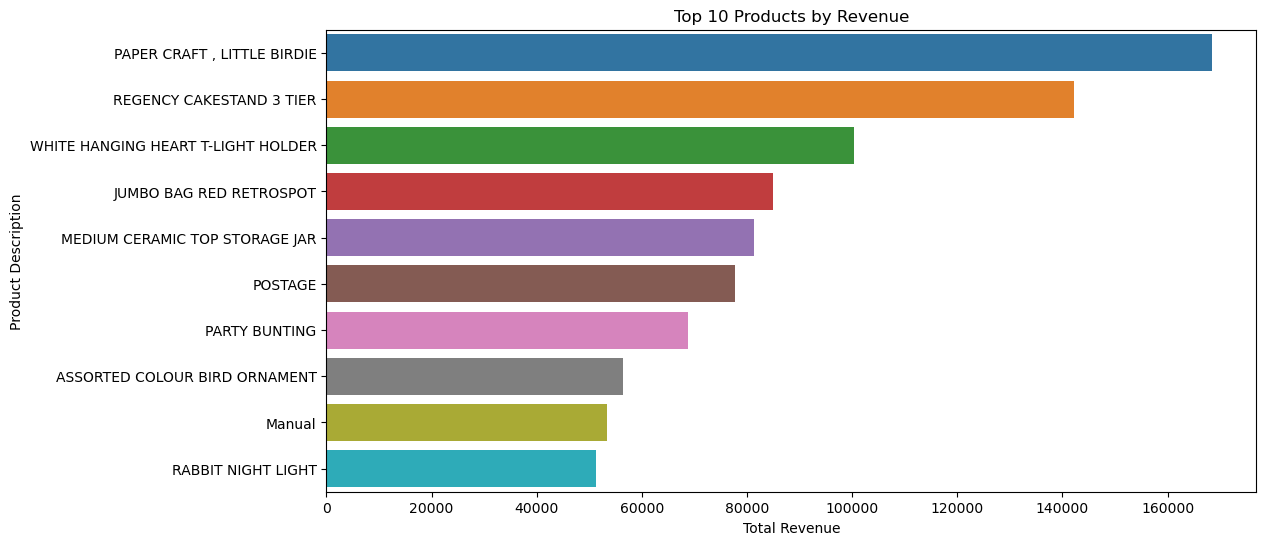

In [101]:
# DataFrame for top 10 revenue-generating products
top10_revenue_products = data.groupby('Description').agg({
    'TotalSales': 'sum'
}).sort_values(by='TotalSales', ascending=False).head(10)

print("Top 10 Products by Revenue:")
print(top10_revenue_products)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_revenue_products['TotalSales'], y=top10_revenue_products.index)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.show()


In [97]:
# Group by StockCode and Country, aggregate sales, and then get the highest selling products per country
country_wise_sales = data.groupby(['StockCode', 'Country']).agg({
    'Quantity': 'sum'
}).sort_values(by=['Country', 'Quantity'], ascending=[True, False])

# We can also use a more complex transformation to only get the top product per country
top_product_per_country = country_wise_sales.reset_index().groupby('Country').head(1)

print("Top Selling Products per Country:")
print(top_product_per_country)


Top Selling Products per Country:
      StockCode               Country  Quantity
0         22492             Australia      2952
599       21918               Austria       288
905       23076               Bahrain        96
921       21212               Belgium       480
1698      21430                Brazil        24
1730      37370                Canada       504
1877      21785       Channel Islands       407
2307      22335                Cyprus       384
2805      22578        Czech Republic        72
2830      21915               Denmark       288
3081      22197                  EIRE      1828
5024      22571    European Community        24
5074     84997D               Finland       552
5532      23084                France      4000
7054      22326               Germany      1221
8718      21615                Greece        48
8856      23076               Iceland       240
8959      20719                Israel       120
9178     51014A                 Italy       240
9651  

Countries with the Most Returns:
                    Quantity
Country                     
United Kingdom          7501
Germany                  453
EIRE                     247
France                   148
USA                      112
Australia                 74
Spain                     48
Italy                     45
Belgium                   38
Japan                     37
Switzerland               35
Portugal                  18
Malta                     15
Norway                    14
Sweden                    11
Poland                    11
Finland                   10
Channel Islands           10
Denmark                    9
Cyprus                     8
Netherlands                8
Singapore                  7
Czech Republic             5
Austria                    3
Israel                     2
Saudi Arabia               1
Greece                     1
European Community         1


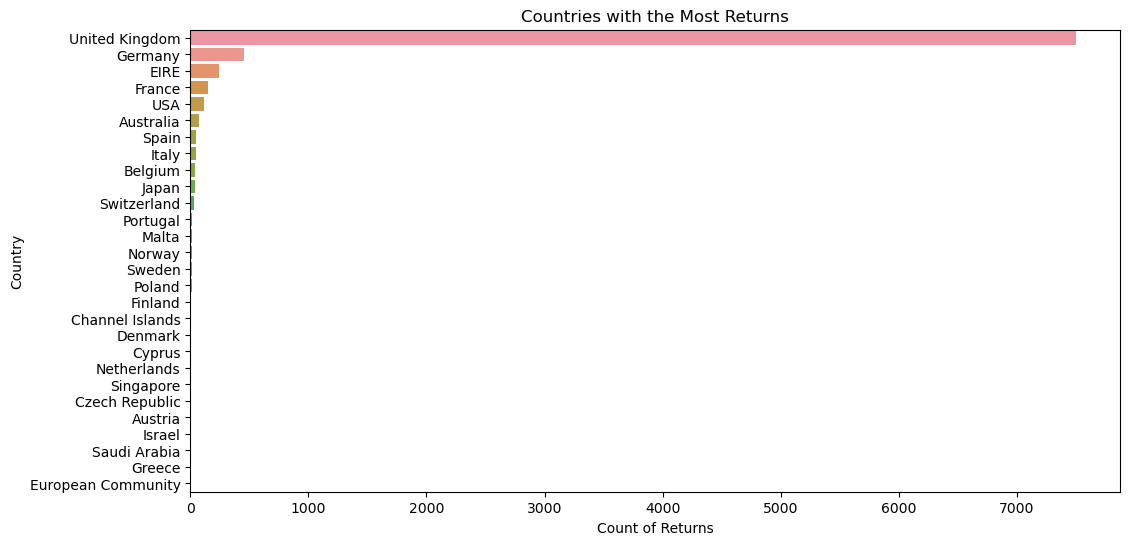

In [102]:
# DataFrame for returns by country
returns_by_country = negative_data.groupby('Country').agg({
    'Quantity': 'count'  # Count the number of returned items per country
}).sort_values(by='Quantity', ascending=False)

print("Countries with the Most Returns:")
print(returns_by_country)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=returns_by_country['Quantity'], y=returns_by_country.index)
plt.title('Countries with the Most Returns')
plt.xlabel('Count of Returns')
plt.ylabel('Country')
plt.show()


In [111]:
# Group by StockCode and Country, aggregate sales, and then get the highest selling products per country
country_wise_sales = data.groupby(['StockCode', 'Country']).agg({
    'Quantity': 'sum'
}).reset_index()

# Sort the results to make it easier to identify the top products
country_wise_sales_sorted = country_wise_sales.sort_values(by=['Country', 'Quantity'], ascending=[True, False])

# Extract the top selling product for each country
top_product_per_country = country_wise_sales_sorted.groupby('Country').first()

print("Top Selling Products per Country:")
print(top_product_per_country[['StockCode', 'Quantity']])


Top Selling Products per Country:
                     StockCode  Quantity
Country                                 
Australia                22492      2952
Austria                  21918       288
Bahrain                  23076        96
Belgium                  21212       480
Brazil                   21430        24
Canada                   37370       504
Channel Islands          21785       407
Cyprus                   22335       384
Czech Republic           22578        72
Denmark                  21915       288
EIRE                     22197      1828
European Community       22571        24
Finland                 84997D       552
France                   23084      4000
Germany                  22326      1221
Greece                   21615        48
Iceland                  23076       240
Israel                   20719       120
Italy                   51014A       240
Japan                    23084      3408
Lebanon                  84929        24
Lithuania              

In [112]:
# Group by StockCode and Country, aggregate sales, and then get the highest selling products per country
country_wise_sales = data.groupby(['StockCode', 'Country'], as_index=False).agg({
    'Quantity': 'sum'
})

# Sorting and getting the top product
country_wise_sales_sorted = country_wise_sales.sort_values(by=['Country', 'Quantity'], ascending=[True, False])
top_product_per_country = country_wise_sales_sorted.groupby('Country').first().reset_index()

# Check the DataFrame
print(top_product_per_country.head())


     Country StockCode  Quantity
0  Australia     22492      2952
1    Austria     21918       288
2    Bahrain     23076        96
3    Belgium     21212       480
4     Brazil     21430        24


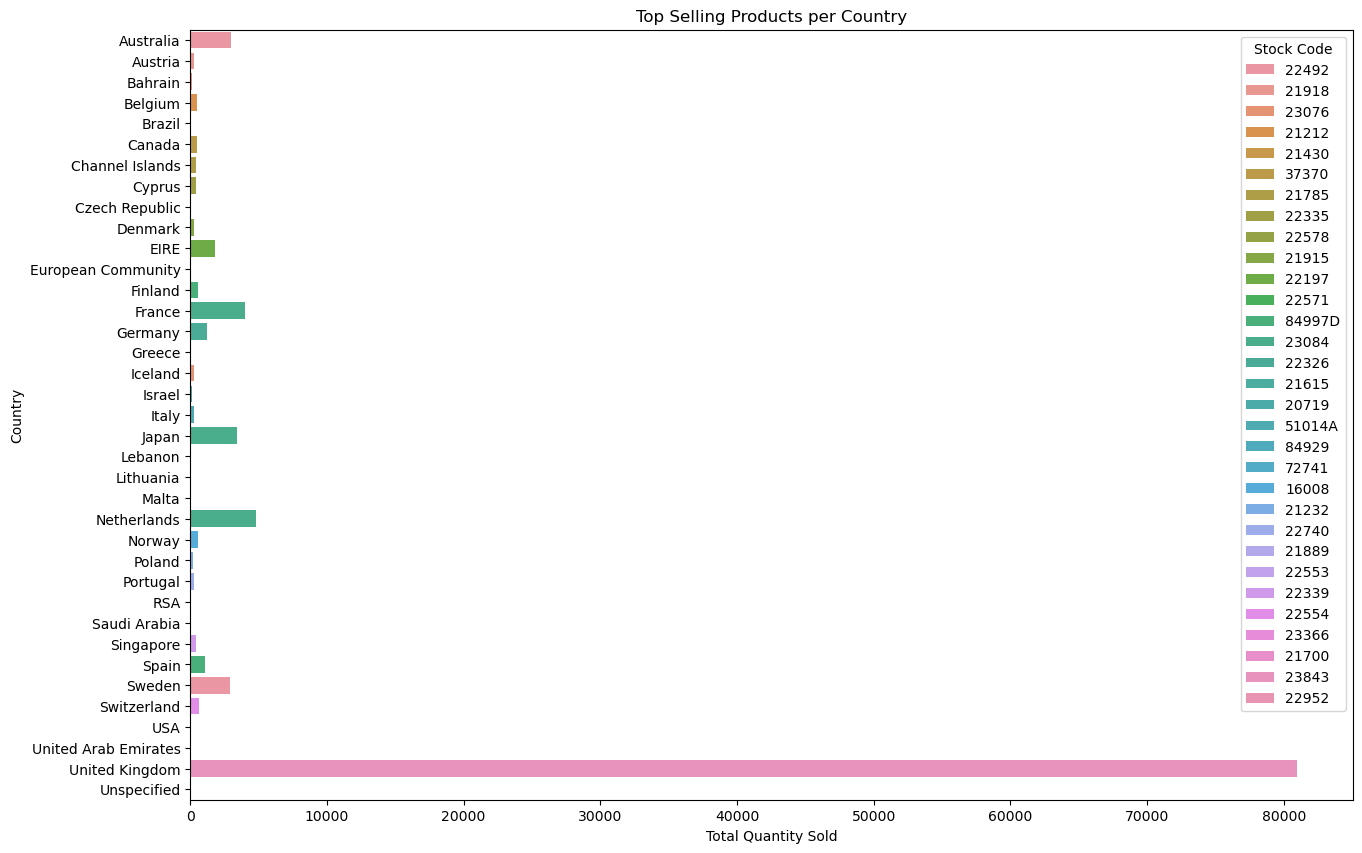

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the plot uses 'Country' correctly
plt.figure(figsize=(15, 10))  # Adjust size as needed depending on the number of countries
sns.barplot(x='Quantity', y='Country', data=top_product_per_country, hue='StockCode', dodge=False)
plt.title('Top Selling Products per Country')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Country')
plt.legend(title='Stock Code')

# Show plot
plt.show()
